In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import multilabel_confusion_matrix, classification_report

In [ ]:
# Загрузка данных
df = pd.read_csv("/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
# Вывод общей информации
df.head()


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
'''Обзор датасета
Датасет Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv содержит информацию о сетевом трафике, собранном в течение рабочего дня в пятницу, с акцентом на атаки типа DDoS (Distributed Denial of Service). Он включает в себя 225745 записей, каждая из которых содержит различные характеристики сетевых потоков.
Описание полей
Flow ID: Уникальный идентификатор потока, который позволяет отслеживать отдельные соединения.
Source IP: IP-адрес источника, откуда инициируется соединение.
Source Port: Порт источника, используемый для отправки данных.
Destination IP: IP-адрес назначения, к которому направляется трафик.
Destination Port: Порт назначения, на который отправляются данные.
Protocol: Протокол, используемый для передачи данных (например, TCP, UDP).
Timestamp: Время, когда был зафиксирован поток данных.
Flow Duration: Продолжительность потока в миллисекундах.
Total Fwd Packets: Общее количество пакетов, отправленных в прямом направлении.
Total Backward Packets: Общее количество пакетов, отправленных в обратном направлении.
Total Length of Fwd Packets: Общая длина пакетов, отправленных в прямом направлении.
Total Length of Bwd Packets: Общая длина пакетов, отправленных в обратном направлении.
Fwd Packet Length Max: Максимальная длина пакета в прямом направлении.
Fwd Packet Length Min: Минимальная длина пакета в прямом направлении.
Fwd Packet Length Mean: Средняя длина пакета в прямом направлении.
Fwd Packet Length Std: Стандартное отклонение длины пакетов в прямом направлении.
Bwd Packet Length Max: Максимальная длина пакета в обратном направлении.
Bwd Packet Length Min: Минимальная длина пакета в обратном направлении.
Bwd Packet Length Mean: Средняя длина пакета в обратном направлении.
Bwd Packet Length Std: Стандартное отклонение длины пакетов в обратном направлении.
Flow Bytes/s: Скорость передачи данных в байтах в секунду.
Flow Packets/s: Скорость передачи пакетов в секунду.
Flow IAT Mean: Средний интервал времени между пакетами.
Flow IAT Std: Стандартное отклонение интервалов времени между пакетами.
Flow IAT Max: Максимальный интервал времени между пакетами.
Flow IAT Min: Минимальный интервал времени между пакетами.
Fwd IAT Total: Общий интервал времени для пакетов в прямом направлении.
Fwd IAT Mean: Средний интервал времени для пакетов в прямом направлении.
Fwd IAT Std: Стандартное отклонение интервалов времени для пакетов в прямом направлении.
Fwd IAT Max: Максимальный интервал времени для пакетов в прямом направлении.
Fwd IAT Min: Минимальный интервал времени для пакетов в прямом направлении.
Bwd IAT Total: Общий интервал времени для пакетов в обратном направлении.
Bwd IAT Mean: Средний интервал времени для пакетов в обратном направлении.
Bwd IAT Std: Стандартное отклонение интервалов времени для пакетов в обратном направлении.
Bwd IAT Max: Максимальный интервал времени для пакетов в обратном направлении.
Bwd IAT Min: Минимальный интервал времени для пакетов в обратном направлении.
Fwd PSH Flags: Количество флагов PSH в пакетах в прямом направлении.
Bwd PSH Flags: Количество флагов PSH в пакетах в обратном направлении.
Fwd URG Flags: Количество флагов URG в пакетах в прямом направлении.
Bwd URG Flags: Количество флагов URG в пакетах в обратном направлении.
Fwd Header Length: Длина заголовка пакетов в прямом направлении.
Bwd Header Length: Длина заголовка пакетов в обратном направлении.
Fwd Packets/s: Скорость передачи пакетов в прямом направлении.
Bwd Packets/s: Скорость передачи пакетов в обратном направлении.
Min Packet Length: Минимальная длина пакета в потоке.
Max Packet Length: Максимальная длина пакета в потоке.
Packet Length Mean: Средняя длина пакета в потоке.
Packet Length Std: Стандартное отклонение длины пакетов в потоке.
Packet Length Variance: Дисперсия длины пакетов в потоке.
FIN Flag Count: Количество пакетов с установленным флагом FIN.
SYN Flag Count: Количество пакетов с установленным флагом SYN.
RST Flag Count: Количество пакетов с установленным флагом RST.
PSH Flag Count: Количество пакетов с установленным флагом PSH.
ACK Flag Count: Количество пакетов с установленным флагом ACK.
URG Flag Count: Количество пакетов с установленным флагом URG.
CWE Flag Count: Количество пакетов с установленным флагом CWE.
ECE Flag Count: Количество пакетов с установленным флагом ECE.
Down/Up Ratio: Соотношение объема загруженных и выгруженных данных.
Average Packet Size: Средний размер пакета в потоке.
Avg Fwd Segment Size: Средний размер сегмента в прямом направлении.
Avg Bwd Segment Size: Средний размер сегмента в обратном направлении.
Fwd Header Length.1: Длина заголовка пакетов в прямом направлении (возможно, дублирующее поле).
Fwd Avg Bytes/Bulk: Среднее количество байтов в пакете в прямом направлении.
Fwd Avg Packets/Bulk: Среднее количество пакетов в прямом направлении.
Fwd Avg Bulk Rate: Средняя скорость передачи данных в прямом направлении.
Bwd Avg Bytes/Bulk: Среднее количество байтов в пакете в обратном направлении.
Bwd Avg Packets/Bulk: Среднее количество пакетов в обратном направлении.
Bwd Avg Bulk Rate: Средняя скорость передачи данных в обратном направлении.
Subflow Fwd Packets: Количество пакетов в подпотоке в прямом направлении.
Subflow Fwd Bytes: Объем данных в подфлоте в прямом направлении.
Subflow Bwd Packets: Количество пакетов в подфлоте в обратном направлении.
Subflow Bwd Bytes: Объем данных в подфлоте в обратном направлении.
Init_Win_bytes_forward: Начальный размер окна в байтах для пакетов в прямом направлении.
Init_Win_bytes_backward: Начальный размер окна в байтах для пакетов в обратном направлении.
act_data_pkt_fwd: Количество активных данных в пакетах в прямом направлении.
min_seg_size_forward: Минимальный размер сегмента в прямом направлении.
Active Mean: Среднее время активности в потоке.
Active Std: Стандартное отклонение времени активности в потоке.
Active Max: Максимальное время активности в потоке.
Active Min: Минимальное время активности в потоке.
Idle Mean: Среднее время простоя в потоке.
Idle Std: Стандартное отклонение времени простоя в потоке.
Idle Max: Максимальное время простоя в потоке.
Idle Min: Минимальное время простоя в потоке.
Label: Метка, указывающая на тип трафика (например, атака или нормальный трафик).'''

In [ ]:
# Вывод общей информации
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       225745 non-null  object 
 1    Source IP                    225745 non-null  object 
 2    Source Port                  225745 non-null  int64  
 3    Destination IP               225745 non-null  object 
 4    Destination Port             225745 non-null  int64  
 5    Protocol                     225745 non-null  int64  
 6    Timestamp                    225745 non-null  object 
 7    Flow Duration                225745 non-null  int64  
 8    Total Fwd Packets            225745 non-null  int64  
 9    Total Backward Packets       225745 non-null  int64  
 10  Total Length of Fwd Packets   225745 non-null  int64  
 11   Total Length of Bwd Packets  225745 non-null  int64  
 12   Fwd Packet Length Max        225745 non-nul

In [ ]:
# Удалим лишние пробелы из названий столбцов и значений
df.columns = df.columns.str.strip()

In [ ]:
# Вывод общей информации
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 85 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow ID                      225745 non-null  object 
 1   Source IP                    225745 non-null  object 
 2   Source Port                  225745 non-null  int64  
 3   Destination IP               225745 non-null  object 
 4   Destination Port             225745 non-null  int64  
 5   Protocol                     225745 non-null  int64  
 6   Timestamp                    225745 non-null  object 
 7   Flow Duration                225745 non-null  int64  
 8   Total Fwd Packets            225745 non-null  int64  
 9   Total Backward Packets       225745 non-null  int64  
 10  Total Length of Fwd Packets  225745 non-null  int64  
 11  Total Length of Bwd Packets  225745 non-null  int64  
 12  Fwd Packet Length Max        225745 non-null  int64  
 13 

In [ ]:
# Проверим пропущенные значения
missing_values = df.isnull().sum()
print("Пропущенные значения:\n", missing_values[missing_values > 0])

Пропущенные значения:
 Flow Bytes/s    4
dtype: int64


In [ ]:
# Удалим пропущенные и бесконечные значения
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [ ]:
# Удаление столбцов с NaN
df_cleaned_columns = df.dropna(axis=1)

In [ ]:
# Проверим пропущенные значения
missing_values = df.isnull().sum()
print("Пропущенные значения:\n", missing_values[missing_values > 0])

Пропущенные значения:
 Series([], dtype: int64)


In [ ]:
print("Уникальные значения метки:", df['Label'].unique())


Уникальные значения метки: ['BENIGN' 'DDoS']


Функция create_attack_labels классифицирует каждый сетевой поток по этапам атаки:

0 - Нормальный трафик (BENIGN)

1 - Разведка (Recon) - определяется по большому количеству пакетов и высокой скорости

2 - Эксплуатация (Exploit) - определяется по большому объему переданных данных

3 - Установка контроля (C&C) - определяется по длительности соединения

4 - Другая подозрительная активность


Обоснование: На этапе разведки злоумышленники часто генерируют большое количество пакетов, чтобы собрать информацию о целевой системе. Высокая скорость передачи данных также может указывать на активное сканирование сети или поиск уязвимостей. Эти параметры помогают выявить подозрительную активность, связанную с разведкой.

Эксплуатация (Exploit):
Характеристика: Total Length of Fwd Packets > 5000
Обоснование: На этапе эксплуатации злоумышленники могут передавать большие объемы данных, чтобы использовать уязвимости в системе. Высокий объем переданных данных может указывать на попытку загрузки вредоносного ПО или выполнения других атакующих действий. Этот параметр помогает выявить такие действия.

Установка контроля (C&C):
Характеристика: Flow Duration > 30000
Обоснование: На этапе установки контроля злоумышленники стремятся установить постоянный доступ к системе. Длительное соединение может указывать на попытку установить связь с командным сервером (C&C) для управления скомпрометированной системой. Этот параметр помогает определить, что соединение может быть частью атаки.

In [ ]:
# Создание multi-label меток для этапов атаки
def create_attack_labels(row):
    labels = []
    if row['Label'] == 'BENIGN':
        labels.append(0)  # Без атаки
    else:
        if row['Total Fwd Packets'] > 1000 and row['Flow Bytes/s'] > 1e6:
            labels.append(1)  # Разведка
        if row['Total Length of Fwd Packets'] > 5000:
            labels.append(2)  # Эксплуатация
        if row['Flow Duration'] > 30000:
            labels.append(3)  # Установка контроля
        if not labels:  # Если ни один этап не подошел
            labels.append(4)  # Другая активность
    return labels

In [ ]:
# Применяем функцию и преобразуем в multi-hot encoding
df['Attack Labels'] = df.apply(create_attack_labels, axis=1)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Attack Labels'])

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


# Подготовка данных для LSTM
features = df.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Label', 'Attack Labels'])

# Нормализация данных
scaler = MinMaxScaler()
X = scaler.fit_transform(features)

maxlen=seq_len: Указывает максимальную длину последовательности, равную 10.

dtype='float32': Указывает тип данных для выходного массива. В данном случае это 32-битные числа с плавающей точкой.

padding='post': Указывает, что дополнение (паддинг) будет происходить в конце последовательности. Если последовательность короче 10, то в конце будут добавлены нули.

truncating='post': Указывает, что если последовательность длиннее 10, то лишние элементы будут удалены с конца.

Группировка данных: Здесь данные из DataFrame df группируются по столбцу Flow ID, который представляет собой уникальный идентификатор для каждой сессии. Это позволяет обрабатывать данные, относящиеся к одной сессии, вместе.
python


sequences = []
seq_labels = []
Инициализация списков: Создаются два пустых списка: sequences для хранения последовательностей признаков и seq_labels для хранения меток, соответствующих этим последовательностям.
python


for flow_id, group in grouped:
Итерация по группам: Цикл проходит по каждой группе, где flow_id — это идентификатор потока, а group — это DataFrame, содержащий все записи, относящиеся к этому идентификатору.
python


if len(group) >= 3:  # Минимум 3 события в сессии
Фильтрация по количеству событий: Проверяется, содержит ли группа как минимум 3 события. Это условие необходимо для того, чтобы гарантировать, что последовательность будет достаточно длинной для анализа.
python


seq_features = scaler.transform(group[features.columns])
Масштабирование признаков: Здесь происходит преобразование признаков группы с использованием предварительно обученного масштабировщика (scaler). Это может быть, например, StandardScaler или MinMaxScaler, который нормализует данные, чтобы они находились в определенном диапазоне. features.columns указывает, какие именно столбцы следует использовать для преобразования.
python


sequences.append(seq_features)
Добавление последовательности: Полученные масштабированные признаки добавляются в список sequences.
python


seq_labels.append(mlb.transform([group['Attack Labels'].iloc[0]])[0])
Добавление меток: Здесь берется первая метка атаки из группы (первое событие) и преобразуется с помощью mlb (MultiLabelBinarizer), который кодирует метки в бинарный формат. Полученная метка добавляется в список seq_labels.

In [ ]:
# Группировка по сессиям (Flow ID) и создание последовательностей
grouped = df.groupby('Flow ID')
sequences = []
seq_labels = []

for flow_id, group in grouped:
    if len(group) >= 3:  # Минимум 3 события в сессии
        seq_features = scaler.transform(group[features.columns])
        sequences.append(seq_features)
        # Берем метки первого события в сессии
        seq_labels.append(mlb.transform([group['Attack Labels'].iloc[0]])[0])

# Приведение к единой длине
seq_len = 10
X = pad_sequences(sequences, maxlen=seq_len, dtype='float32', padding='post', truncating='post')
y = np.array(seq_labels)

Модель содержит:

Masking слой для обработки переменной длины последовательностей

LSTM слой с 128 нейронами

Полносвязные слои с dropout для регуляризации

Выходной слой с сигмоидальной активацией (для multi-label классификации)

Создание модели: Здесь создается последовательная модель нейронной сети:
Masking: Этот слой игнорирует входные значения, равные 0.0, что полезно для обработки последовательностей с паддингом.

LSTM(128, return_sequences=False): Слой LSTM с 128 нейронами. Параметр return_sequences=False указывает, что на выходе будет возвращено только последнее состояние, а не последовательность состояний.

Dropout(0.4): Слой Dropout с вероятностью 0.4, который отключает 40% нейронов во время обучения для предотвращения переобучения.
Dense(64, activation='relu'): Полносвязный слой с 64 нейронами и активацией ReLU.

Dropout(0.3): Еще один слой Dropout с вероятностью 0.3.

Dense(y.shape[1], activation='sigmoid'): Выходной слой, количество нейронов соответствует числу меток (классов). Активация sigmoid используется для многометочной классификации.

Компиляция модели: Здесь модель компилируется с использованием оптимизатора Adam, функции потерь binary_crossentropy (подходящей для многометочной классификации) и метрик для оценки производительности модели (точность, точность и полнота).

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Построение модели
model = Sequential([
    Masking(mask_value=0.0, input_shape=(seq_len, X.shape[2])),
    LSTM(128, return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='sigmoid')  # Выходной слой по числу меток
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

   # Обучение multi-label модели
history = model.fit(X_train, y_train,
                   validation_data=(X_test, y_test),
                   epochs=10,
                   batch_size=128)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_10 (Masking)            │ (None, 10, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 128)            │       107,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,459 (451.01 KB)

 Trainable params: 115,459 (451.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - Precision: 0.7925 - Recall: 0.7453 - accuracy: 0.7794 - loss: 0.3561 - val_Precision: 0.9403 - val_Recall: 0.9403 - val_accuracy: 0.9403 - val_loss: 0.1475
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - Precision: 0.9366 - Recall: 0.9361 - accuracy: 0.9364 - loss: 0.1589 - val_Precision: 0.9446 - val_Recall: 0.9446 - val_accuracy: 0.9446 - val_loss: 0.1365
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - Precision: 0.9460 - Recall: 0.9458 - accuracy: 0.9460 - loss: 0.1373 - val_Precision: 0.9449 - val_Recall: 0.9449 - val_accuracy: 0.9449 - val_loss: 0.1315
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - Precision: 0.9459 - Recall: 0.9458 - accuracy: 0.9459 - loss: 0.1346 - val_Precision: 0.9449 - val_Recall: 0.9449 - val_accuracy: 0.9449 - val_loss: 0.1320
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - Precision: 0.9441 - Recall: 0.9438 - accuracy: 0.9441 - loss: 0.1380 - val_Precision: 0.9449 - val_

(None, 10, 80) означает, что выходные данные имеют 10 временных шагов и 80 признаков на временной шаг.

107,008 — это количество параметров, которые LSTM обучает

(None, 3) — выходной вектор размером 3, что соответствует количеству меток для многометочной классификации.

Precision (Точность):
Это метрика, показывающая, насколько точно модель предсказывает положительные классы. Она рассчитывается как отношение истинных положительных предсказаний (TP) к общему числу предсказанных положительных классов (TP + FP). В данном случае точность составляет 0.7925, что означает, что 79.25% предсказанных положительных классов действительно являются положительными.

Recall (Полнота):
Это метрика, показывающая, насколько хорошо модель находит все положительные примеры. Она рассчитывается как отношение истинных положительных предсказаний (TP) к общему числу фактических положительных классов (TP + FN). Полнота составляет 0.7453, что означает, что модель находит 74.53% всех фактических положительных классов.

Accuracy (Точность):
Это общая метрика, показывающая долю правильных предсказаний (как положительных, так и отрицательных) среди всех предсказаний. В данном случае точность составляет 0.7794, что означает, что 77.94% всех предсказаний модели были правильными.

Loss (Потери):
Это значение функции потерь, которое показывает, насколько хорошо модель предсказывает результаты. В данном случае значение потерь составляет 0.3561. Низкое значение потерь указывает на то, что модель хорошо предсказывает классы.
val_Precision, val_Recall, val_accuracy, val_loss:
Эти метрики аналогичны вышеописанным, но они относятся к валидационному набору данных (т.е. к данным, которые не использовались для обучения модели). Они помогают оценить, как хорошо модель обобщается на новых данных. Например, val_Precision: 0.9403 указывает на высокую точность на валидационном наборе.

np.where(y_test == 1)[1] для нахождения индексов классов, которые присутствуют в тестовых данных. np.unique возвращает уникальные классы, которые были предсказаны моделью

матрицу ошибок для многометочной классификации. Она возвращает массив, где каждая матрица соответствует одному классу и показывает количество истинных положительных, ложных положительных, ложных отрицательных и истинных отрицательных предсказаний

Точность (Accuracy): доля правильных предсказаний.

Полнота (Recall): способность модели находить все положительные примеры.

Точность (Precision): доля правильных положительных предсказаний среди всех положительных предсказаний.

F1-мера: гармоническое среднее между точностью и полнотой, что полезно, когда необходимо учитывать оба аспекта.

In [ ]:
# После получения y_pred добавим проверку классов
present_classes = np.unique(np.where(y_test == 1)[1])
print("Присутствующие классы в тестовых данных:", present_classes)

# Обновим target_names в соответствии с классами
target_names = ['Normal', 'Recon', 'Exploit', 'C&C', 'Other']
filtered_targets = [target_names[i] for i in present_classes]

# Вывод classification_report с правильными параметрами
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                          labels=present_classes,
                          target_names=filtered_targets,
                          zero_division=0))

# Confusion matrix
mcm = multilabel_confusion_matrix(y_test[:, present_classes],
                                 y_pred[:, present_classes])

for i, idx in enumerate(present_classes):
    print(f"\n{target_names[idx]} Confusion Matrix:")
    print(mcm[i])
    tn, fp, fn, tp = mcm[i].ravel()
    print(f"True Positives: {tp}, False Positives: {fp}")
    print(f"False Negatives: {fn}, True Negatives: {tn}")

Присутствующие классы в тестовых данных: [0 1 2]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       889
       Recon       0.93      1.00      0.96      3054
     Exploit       0.00      0.00      0.00       230

   micro avg       0.94      0.94      0.94      4173
   macro avg       0.64      0.67      0.65      4173
weighted avg       0.89      0.94      0.92      4173
 samples avg       0.94      0.94      0.94      4173


Normal Confusion Matrix:
[[3284    0]
 [   0  889]]
True Positives: 889, False Positives: 0
False Negatives: 0, True Negatives: 3284

Recon Confusion Matrix:
[[ 889  230]
 [   0 3054]]
True Positives: 3054, False Positives: 230
False Negatives: 0, True Negatives: 889

Exploit Confusion Matrix:
[[3943    0]
 [ 230    0]]
True Positives: 0, False Positives: 0
False Negatives: 230, True Negatives: 3943


Визуализация timeline heatmap
Преобразует временные метки в формат datetime

Группирует атаки по 5-минутным интервалам

Считает количество атак каждого типа в каждом интервале

Строит тепловую карту активности атак по времени

sum(1 for labels in x if 1 in labels) — это выражение считает количество событий, относящихся к этапу Recon (где метка равна 1). Аналогично для других этапов.

<ipython-input-185-0cf2c80ec1e3>:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  attack_df['Time Window'] = attack_df['Timestamp'].dt.floor('5T')  # 5-минутные окна


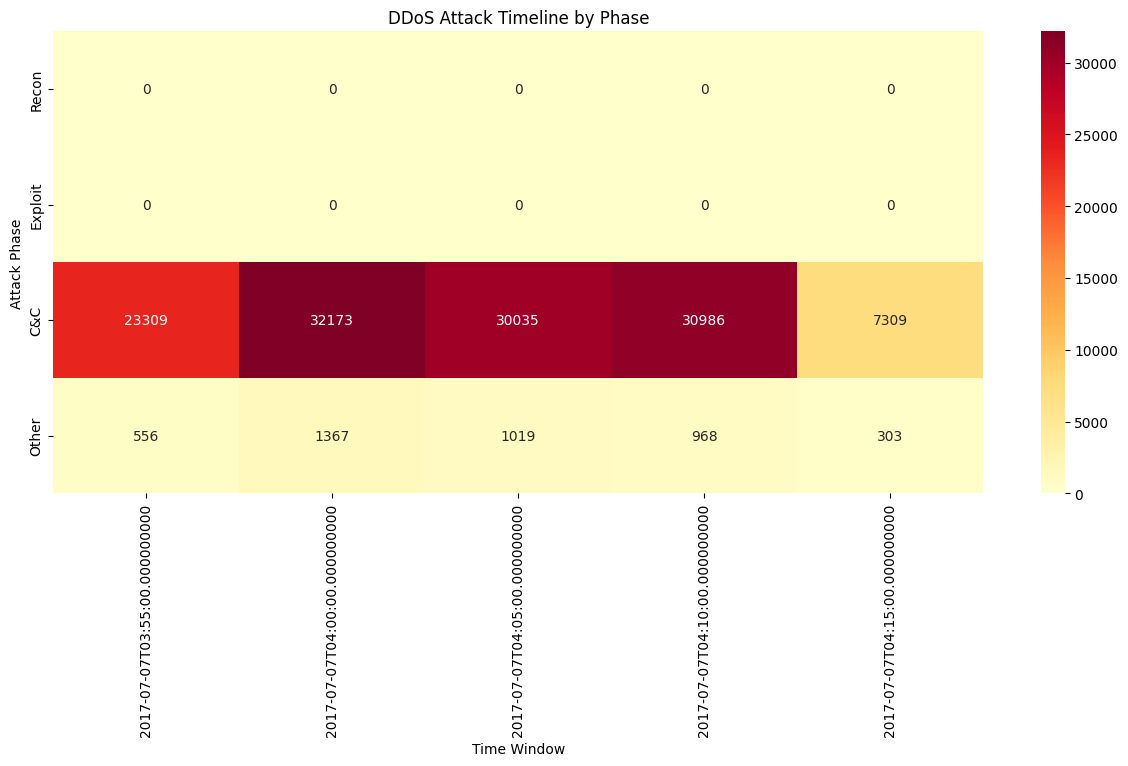

In [ ]:
# Timeline Heatmap
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
attack_df = df[df['Label'] == 'DDoS'].copy()
attack_df['Time Window'] = attack_df['Timestamp'].dt.floor('5T')  # 5-минутные окна

# Подсчет активности по этапам в каждом окне
phase_activity = attack_df.groupby('Time Window')['Attack Labels'].apply(
    lambda x: pd.Series({
        'Recon': sum(1 for labels in x if 1 in labels),
        'Exploit': sum(1 for labels in x if 2 in labels),
        'C&C': sum(1 for labels in x if 3 in labels),
        'Other': sum(1 for labels in x if 4 in labels)
    })
).unstack()

# Визуализация heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(phase_activity.T, cmap='YlOrRd', annot=True, fmt='d')
plt.title('DDoS Attack Timeline by Phase')
plt.xlabel('Time Window')
plt.ylabel('Attack Phase')
plt.show()